In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob


In [4]:
rootF = '/home/bdudas/PCT_DATA/output/'
wpts = [100,150,175,200]
dataFolders = [f'{rootF}/wpt_{wpt}_psa' for wpt in wpts]


In [32]:
sammpleID = 1
sampleWPT = np.random.choice(wpts)

# Load Data

In [8]:

tmp_hit = np.load(glob.glob(f"{rootF}/wpt_{sampleWPT}_psa/*_{sammpleID}.hits.npy")[0])
tmp_psa = np.load(glob.glob(f"{rootF}/wpt_{sampleWPT}_psa/*_{sammpleID}_AllPSA.npy")[0], allow_pickle=True)
hit = pd.DataFrame(tmp_hit)
psa = pd.DataFrame(tmp_psa)
hit = hit[hit.parentID == 0]
psa = psa[psa.ParentID == 0]
hit['Layer'] =  2*(hit['volumeID[2]'])+hit['volumeID[3]']


In [9]:
df = hit.sort_values(['eventID','Layer']).loc[:,['eventID','Layer','edep']]
df

,eventID,Layer,edep
21,1,0,0.018229
22,1,1,0.023567
23,1,2,0.021172
24,1,3,0.035010
25,1,4,0.019598
...,...,...,...
22638,999,19,0.035783
22639,999,20,0.057409
22640,999,21,0.068108
22641,999,22,0.071473


array([[<AxesSubplot:title={'center':'edep'}>]], dtype=object)

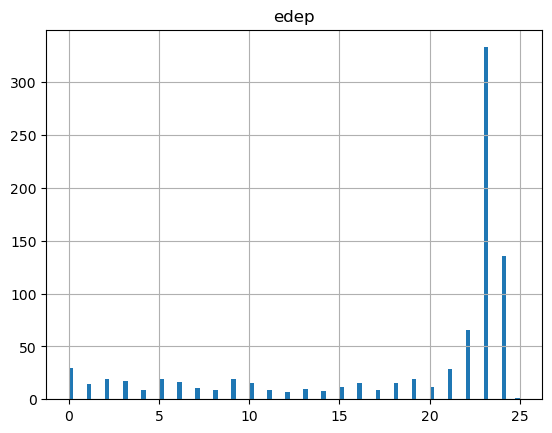

In [10]:
df.groupby('eventID').agg({'edep':np.argmax}).hist(bins=100)

In [11]:
df_psa = psa.groupby('EventID').max('Ekine').loc[:,['Ekine']]

In [12]:
df_psa.reset_index(inplace=True)
df_psa = df_psa[df_psa.EventID.isin(df.eventID)]

In [13]:
savePath = f'data/wpt_{sampleWPT}/{sammpleID}'
np.save(f'{savePath}_y.npy', df_psa.Ekine.values)
np.save(f'{savePath}_x.npy', df.edep.values)

In [14]:
all(np.load(f'{savePath}_x.npy') == df.edep.values)

True

In [15]:
def padarray(A,size = 41):
    t = size - len(A)
    if t > 0:
        return np.pad(A, (0,t), 'constant', constant_values=(0,0))
    else:
        return A

In [16]:
edep_arrays = [padarray(group['edep'].values) for _, group in df.groupby('eventID')]

In [21]:
np.save('tmp.npy', edep_arrays)
xx = np.load('tmp.npy')
xx.shape

(859, 41)

# Prediction

In [5]:
x = np.load(f'data/wpt_{sampleWPT}/{sammpleID}_x.npy')
y = np.load(f'data/wpt_{sampleWPT}/{sammpleID}_y.npy')

In [7]:
x.shape, y.shape

((834, 41), (834,))

In [12]:
argmxs = np.argmax(x,axis=1)
mostPopularLayer = np.bincount(argmxs).argmax()
mostPopularLayer

20

In [29]:
for wpt in wpts:
    tmp = np.load(f'utils/wpt_{sampleWPT}_armgxs.npy')
    mostCommonValue = np.bincount(tmp).argmax()
    np.save(f'utils/wpt_{wpt}_targetlayer.npy', mostCommonValue)


In [45]:
x = np.load(f'data/wpt_{sampleWPT}/{sammpleID}_x.npy')
y = np.load(f'data/wpt_{sampleWPT}/{sammpleID}_y.npy')
targetlayer = np.load(f'utils/wpt_{sampleWPT}_targetlayer.npy')

In [62]:
from utils.filter import layer_filter

In [53]:
argmxs = np.argmax(x, axis=1)
c1 = argmxs == targetlayer
c2 = argmxs == targetlayer-1
c3 = argmxs == targetlayer+1
argmxs[c1 | c2 | c3].shape

(475,)

In [70]:
c1

array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True,  True, False, False, False,
       False, False, False, False, False,  True,  True, False, False,
        True,  True, False,  True,  True,  True, False, False, False,
        True, False, False, False, False,  True, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True, False, False,  True, False, False,  True, False,
       False,  True, False, False,  True,  True, False, False,  True,
       False,  True, False,  True, False, False,  True, False, False,
       False, False,  True, False, False, False, False, False, False,
        True, False, False, False, False, False,  True, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False,  True,

In [71]:
def getPeakData(x,targetlayer):
    x1 = x[:,targetlayer]
    x2 = x[:,targetlayer-1]
    x3 = x[:,targetlayer+1]
    x = np.column_stack((x1,x2,x3))
    return x

In [73]:
tmpx,tmpy = layer_filter(x, y, targetlayer)

tmpx.shape

(475, 41)

In [74]:
tmpx = tmpx[:200]

In [77]:
tmpx.shape

(200, 41)